In [1]:
#!pip install --user pyarrow
#!pip install --user -U pandas

In [1]:
import bioframe as bf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from scipy.stats import spearmanr, mannwhitneyu, fisher_exact
from scipy.special import expit as sigmoid
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

In [2]:
chroms = [
    #"Chr1",
    #"Chr2",
    "Chr5",
]
conservation = {
    chrom: pd.read_csv(f"../data/vep/conservation/{chrom}.tsv.gz", sep="\t")
    for chrom in chroms
}
#conservation = pd.read_csv("../data/vep/conservation/Chr1.tsv.gz", sep="\t")
conservation

{'Chr5':                pos  PhastCons    PhyloP
 0               73   0.137841  0.486723
 1               74   0.120058  0.630370
 2               75   0.082986 -0.672660
 3               76   0.083501  0.630370
 4               77   0.070315  0.410230
 ...            ...        ...       ...
 24279498  26975493   0.149043  0.383414
 24279499  26975494   0.139126  0.383414
 24279500  26975495   0.121064 -0.819180
 24279501  26975496   0.144156  0.383414
 24279502  26975497   0.158717  0.453181
 
 [24279503 rows x 3 columns]}

In [3]:
"""
repeats = pd.read_csv("../data/mlm/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))
repeats = repeats.query('chrom == "Chr5"')
repeats
"""

'\nrepeats = pd.read_csv("../data/mlm/repeats.bed.gz", sep="\t").rename(columns=dict(genoName="chrom", genoStart="start", genoEnd="end"))\nrepeats = repeats.query(\'chrom == "Chr5"\')\nrepeats\n'

In [4]:
def compute_odds_ratio(df, threshold_quantile, print_table=False, bootstrap_seed=None):
    df = df.copy()
    if bootstrap_seed is not None:
        df = df.sample(frac=1.0, replace=True, random_state=bootstrap_seed)
    threshold = df.model_score.quantile(threshold_quantile)
    df.loc[df.model_score <= threshold, "ModelScoreTier"] = "Low"
    df.loc[df.model_score > threshold, "ModelScoreTier"] = "High"
    df.ModelScoreTier = df.ModelScoreTier.astype('category')
    group_counts = df.groupby(["Status", "ModelScoreTier"]).size()
    
    #print("Adding 1 pseudocount")
    #group_counts += 1
    if print_table:
        print(group_counts)
    
    group_counts2 = group_counts.copy()
    #print(threshold_quantile, threshold, group_counts["Rare", "Low"]+group_counts["Common", "Low"], df.model_score.min())
    group_counts = group_counts.values.reshape((2, 2))
    min_counts = group_counts.min()
    odds_ratio, p_value = fisher_exact(group_counts, alternative='greater')
    if np.isinf(odds_ratio):
        print(odds_ratio, p_value, group_counts2)
    return odds_ratio, p_value, min_counts


def compute_vep_scores(model_name, n_bootstrap=3):
    print(model_name)
    if model_name in ["PhastCons", "PhyloP", "PhyloP_ReLU", "PhyloP_abs"]:
        df = pd.read_parquet("../data/vep/variants/filt.Chr5.parquet")
    else:
        #vep_mode, model_name2 = model_name.split("/")
        #df = pd.read_parquet(f"../plantbert/{vep_mode}/vep_full_{model_name2}.parquet")
        df = pd.read_parquet(model_name)
        if "mlm" in model_name:
            vep_mode = "mlm"
        elif "chromatin" in model_name:
            vep_mode = "chromatin"
    df = df[df.AN >= 2000]
    df = df[(df.AC != 0) & (df.AC != df.AN)]
    df["AF"] = df.AC / df.AN
    df = df[df.AF < 0.5]
    #print(df.shape)
    df = df.merge(conservation[df.chromosome.iloc[0]], how="inner", on="pos")
    #print(df.shape)
    df.consequence = df.consequence.apply(lambda x: ','.join(sorted(list(set(x.split(","))))))
    
    """
    df["chrom"] = df.chromosome
    df["start"] = df.pos
    df["end"] = df.start + 1
    df = bf.coverage(df, repeats)
    df.loc[df.coverage==1, "consequence"] = "repeat"
    """
    
   
    
    # TODO: figure this out
    #df.loc[(df.dist_to_TSS >= -1000) & (df.dist_to_TSS <= 0) & (df.consequence=="upstream_gene_variant"), "consequence"] = "upstream_1kb"
    
    # TODO: for loop
    #rare_thresholds = np.arange(2, 12, 2)
    #common_thresholds = np.arange(10, 110, 10)
    
    df["Status"] = "Neither"
    df.loc[df.AC <= 2, "Status"] = "Rare"
    df.loc[df.AC >= 20, "Status"] = "Common"
    df = df[df.Status!="Neither"]
    df.Status = df.Status.astype('category')
    #raise Exception("debug")
    
    if model_name == "PhastCons":
        df["model_score"] = -df.PhastCons
    elif model_name == "PhyloP":
        df["model_score"] = -(df.PhyloP)
    elif vep_mode == "chromatin":
        pred_ref_cols = df.columns[df.columns.str.startswith("model_pred_ref_")]
        pred_alt_cols = df.columns[df.columns.str.startswith("model_pred_alt_")]
        pred_cols = np.concatenate([pred_ref_cols, pred_alt_cols])
        df[pred_cols] = sigmoid(df[pred_cols])
        feature_names = ["_".join(col.split("_")[3:]) for col in pred_ref_cols]
        delta_pred_cols = [f"delta_pred_{f}" for f in feature_names]
        df.loc[:, delta_pred_cols] = df[pred_alt_cols].values - df[pred_ref_cols].values
        df.loc[:, "model_score"] = -np.linalg.norm(df[delta_pred_cols].abs().values, ord=2, axis=1)
        df.drop(columns=np.concatenate([pred_cols, delta_pred_cols]), inplace=True)
    elif vep_mode == "mlm":
        df["model_score"] = df.model_llr
        
    threshold_quantiles = np.logspace(-3, -1, 10)
    bootstrap_seeds = np.arange(n_bootstrap)
    
    categories = ["all"] + df.consequence.value_counts()[:8].index.values.tolist()
    
    all_results = []
    for category in categories:
        #print(category)
        df_category = df if category == "all" else df[df.consequence==category]
        
        odds_ratios, p_values, min_counts = zip(*[compute_odds_ratio(df_category, threshold_quantile) for threshold_quantile in threshold_quantiles])
        results = pd.DataFrame(dict(threshold_quantile=threshold_quantiles, odds_ratio=odds_ratios, p_value=p_values, min_count=min_counts))
        results["Test"] = "Odds-ratio"
        
        
        for bootstrap_seed in bootstrap_seeds:
            odds_ratios = [compute_odds_ratio(df_category, threshold_quantile, bootstrap_seed=bootstrap_seed)[0] for threshold_quantile in threshold_quantiles]
            #print(odds_ratios)
            #raise Exception("debug")
            results = pd.concat([
                results,
                pd.DataFrame({
                    "Test": ["Odds-ratio-bootstrap"] * len(threshold_quantiles),
                    "threshold_quantile": threshold_quantiles,
                    "bootstrap_seed": [bootstrap_seed] * len(threshold_quantiles),
                    "odds_ratio": odds_ratios,
                    "p_value": p_values, "min_count": min_counts,  # from the non-bootstrapped test
                })],
                ignore_index=True
            )
            #print(results)
            #raise Exception("debug")
        
        results = results.append({
            "Test": "Mann-Whitney",
            "p_value": mannwhitneyu(df_category.loc[df.Status=="Rare", "model_score"], df_category.loc[df.Status=="Common", "model_score"], alternative="less").pvalue
        }, ignore_index=True)
        
        results = results.append({
            "Test": "AUROC",
            "AUROC": roc_auc_score((df_category.Status=="Rare").values, -df_category.model_score.values)
        }, ignore_index=True)
        
        precision, recall, thresholds = precision_recall_curve((df_category.Status=="Rare").values, -df_category.model_score.values)
        results = results.append({
            "Test": "AUPRC",
            "AUPRC": auc(recall, precision),
        }, ignore_index=True)
        
        results["Category"] = category
        all_results.append(results)
    all_results = pd.concat(all_results, ignore_index=True)
    all_results["Model"] = model_name
    all_results["Significant"] = all_results.p_value < 0.05
    
    return all_results, df

In [5]:
model_names = [
    #"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_ftAth_alone_checkpoint-1000000/results.parquet",
    #"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr1.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet",
    #"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr2.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet",    

    #"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_checkpoint-1000000/results.parquet",
    #"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_checkpoint-1100000/results.parquet",
    #"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_checkpoint-1200000/results.parquet",
    #"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_checkpoint-1300000/results.parquet",
    #"../plantbert/mlm/vep_full_results_512_convnet_checkpoint-1000000.parquet",

    #"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr1.parquet/results_512_convnet_ftAth_alone_checkpoint-1000000/results.parquet",
    #"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_512_no_repeats_convnet_pretrained_v2_checkpoint-200000/results.parquet",
    #"mlm/ensemble_3.avg",
    #"mlm/ensemble_3.min",
    #"mlm/results_512_convnet_checkpoint-1000000",
    #"mlm/results_512_convnet_ftAth_alone_checkpoint-100000",
    #"mlm/results_512_convnet_ftAth_alone_checkpoint-800000",
    #"mlm/window-512_tokenization-no_model-convnet200k",
    #"mlm/window-512_tokenization-no_model-convnet",
    #"mlm/window-512_tokenization-no_model-convnet800k",
    #"mlm/window-512_tokenization-no_model-convnet800kfinetune150k",
    #"mlm/window-512_tokenization-no_model-convnet800kfinetune200k",
    #"mlm/window-512_tokenization-no_model-convnet_only_athaliana",
    #"mlm/window-512_tokenization-no_model-convnet_ftAth_alone",
    #"mlm/window-512_tokenization-no_model-convnet_ftAth_alone",
    #"mlm/window-512_tokenization-no_model-convnet_ftAth",
    
    "mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet",
    #"mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_nr_convnet_m50k_30l_1e-3_checkpoint-50000/results.parquet",
    ##"mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_convnet_v3_checkpoint-1000000/results.parquet",
    #"mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_nr2_convnet_m200k_30l_1e-3_checkpoint-140000/results.parquet",
    "mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_nr3_convnet_m200k_30l_1e-3_checkpoint-200000/results.parquet",
    "mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_nr4_convnet_m500k_30l_1e-3_checkpoint-200000/results.parquet",


    #"../plantbert/mlm/vep_full_DNABERT.parquet",
    #"../plantbert/chromatin/vep_full_ConvNet.parquet",
    #"../plantbert/chromatin/vep_full_DNABERT.parquet",
    #"../plantbert/chromatin/vep_full_DeepSEA.parquet",
    #"PhastCons",
    #"PhyloP",
]

results = pd.concat(
    [compute_vep_scores(model_name)[0] for model_name in model_names],
    ignore_index=True
)

mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet
mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_nr3_convnet_m200k_30l_1e-3_checkpoint-200000/results.parquet
mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_nr4_convnet_m500k_30l_1e-3_checkpoint-200000/results.parquet


In [19]:
#results.to_csv(f"odds_ratios.tsv.gz", sep="\t", index=False)
#results = pd.read_csv("foo.tsv.gz", sep="\t")

In [21]:
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet200k": "mlm/ConvNet-200k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet": "mlm/ConvNet-400k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800k": "mlm/ConvNet-800k"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800k": "mlm/ConvNet"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800kfinetune150k": "mlm/ConvNet-finetune-athaliana"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800kfinetune200k": "mlm/ConvNet"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet800kfinetune200k": "ConvNet (800k 20 species + 200k only Arabidopsis)"}, inplace=True)
#results.Model.replace({"mlm/window-512_tokenization-no_model-convnet_only_athaliana": "ConvNet (500k only Arabidopsis)"}, inplace=True)

In [22]:
# deal with infinite odds ratio
results.odds_ratio.max()

inf

In [23]:
#results.odds_ratio.replace({np.inf: 20.0}, inplace=True)

In [24]:
#results.odds_ratio.max()

In [72]:
#results = results[~(results.Model.isin(["PhyloP_abs", "PhyloP_ReLU"]))]

In [73]:
#results = results[results.Model.str.contains("mlm/ConvNet")]

In [6]:
#results = results[~results.Model.str.contains("00k")]

In [25]:
df = compute_vep_scores("PhyloP")[1]

PhyloP


In [26]:
consequence_value_counts = df.consequence.value_counts()

In [27]:
def get_category_n(category):
    if category == "all": return len(df)
    return consequence_value_counts[category]

In [28]:
results["category_n"] = results.Category + " (n=" + results.Category.apply(get_category_n).astype(str) + ")"
results.category_n

0                           all (n=907246)
1                           all (n=907246)
2                           all (n=907246)
3                           all (n=907246)
4                           all (n=907246)
                       ...                
63814    downstream_gene_variant (n=30852)
63815    downstream_gene_variant (n=30852)
63816    downstream_gene_variant (n=30852)
63817    downstream_gene_variant (n=30852)
63818    downstream_gene_variant (n=30852)
Name: category_n, Length: 63819, dtype: object

In [22]:
#results.Model.replace({"mlm/results_512_convnet_checkpoint-1000000": "1M(all)"}, inplace=True)
#results.Model.replace({"mlm/results_512_convnet_ftAth_alone_checkpoint-100000": "1M(all)->100K(arabidopsis)"}, inplace=True)
#results.Model.replace({"mlm/results_512_convnet_ftAth_alone_checkpoint-800000": "1M(all)->800K(arabidopsis)"}, inplace=True)

In [22]:
#results.Model.replace({"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_ftAth_alone_checkpoint-1000000/results.parquet": "Base model"}, inplace=True)
#results.Model.replace({"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_512_no_repeats_convnet_pretrained_v2_checkpoint-200000/results.parquet": "Base model -> pretrain w/o loss on repeats"}, inplace=True)

In [56]:
"""results.Model.replace({
    "../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_checkpoint-1000000/results.parquet": "1M(Ath)",
    "../plantbert/mlm/vep_full_results_512_convnet_checkpoint-1000000.parquet": "1M(All)",
    "../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_ftAth_alone_checkpoint-1000000/results.parquet": "1M(All)->1M(Ath)"
    },
    inplace=True,
)
"""

In [14]:
"""results.Model.replace({
    "../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_checkpoint-1100000/results.parquet": "1.1M",
    "../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_checkpoint-1200000/results.parquet": "1.2M",
    "../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_checkpoint-1300000/results.parquet": "1.3M",
    },
    inplace=True,
)
results = results[results.Model.str.contains("M")]
"""

In [5]:
#results.Model.replace({"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_ftAth_alone_checkpoint-1000000/results.parquet": "1M(all)->1M(Ath)"}, inplace=True)
#results.Model.replace({"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet": "1M(Ath)->80K(Ath,lower lr)"}, inplace=True)

In [5]:
#results.Model.replace({"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet": "Chr5 (test)"}, inplace=True)
#results.Model.replace({"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr1.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet": "Chr1 (train)"}, inplace=True)
#results.Model.replace({"../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr2.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet": "Chr2 (train)"}, inplace=True)

In [29]:
results.Model.value_counts()

../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet    9117
../plantbert/mlm/vep_full_DNABERT.parquet                                                                                                                  9117
../plantbert/chromatin/vep_full_ConvNet.parquet                                                                                                            9117
../plantbert/chromatin/vep_full_DNABERT.parquet                                                                                                            9117
../plantbert/chromatin/vep_full_DeepSEA.parquet                                                                                                            9117
PhastCons                                                                                                                                                  9117
PhyloP                                  

In [30]:
results.Model.replace({
    "../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet": "GPN",
    "../plantbert/mlm/vep_full_DNABERT.parquet": "DNABERT",
    "../plantbert/chromatin/vep_full_ConvNet.parquet": "GPN-Epigenetics",
    "../plantbert/chromatin/vep_full_DNABERT.parquet": "DNABERT-Epigenetics",
    "../plantbert/chromatin/vep_full_DeepSEA.parquet": "DeepSEA",    
    },
    inplace=True,
)

In [31]:
results.Model.value_counts()

GPN                    9117
DNABERT                9117
GPN-Epigenetics        9117
DNABERT-Epigenetics    9117
DeepSEA                9117
PhastCons              9117
PhyloP                 9117
Name: Model, dtype: int64

In [44]:
#results.sort_values("Model", kind="stable", inplace=True)

In [43]:
results[(results.odds_ratio==np.inf)]

,threshold_quantile,odds_ratio,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant,category_n
8164,0.001,inf,0.001433,5.0,Odds-ratio-bootstrap,5.0,NaN,NaN,downstream_gene_variant,GPN,True,downstream_gene_variant (n=30852)
8304,0.001,inf,0.001433,5.0,Odds-ratio-bootstrap,19.0,NaN,NaN,downstream_gene_variant,GPN,True,downstream_gene_variant (n=30852)


In [28]:
#results.to_csv(f"odds_ratios_polished.tsv.gz", sep="\t", index=False)
results = pd.read_csv("odds_ratios_polished.tsv.gz", sep="\t")
results

,threshold_quantile,odds_ratio,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant,category_n
0,0.001000,2.728865,4.944034e-42,200.0,Odds-ratio,NaN,NaN,NaN,all,GPN,True,all (n=907246)
1,0.001668,2.375922,1.214560e-53,371.0,Odds-ratio,NaN,NaN,NaN,all,GPN,True,all (n=907246)
2,0.002783,2.428471,5.762943e-92,609.0,Odds-ratio,NaN,NaN,NaN,all,GPN,True,all (n=907246)
3,0.004642,2.235548,5.637036e-128,1082.0,Odds-ratio,NaN,NaN,NaN,all,GPN,True,all (n=907246)
4,0.007743,2.005910,3.203085e-163,1956.0,Odds-ratio,NaN,NaN,NaN,all,GPN,True,all (n=907246)
...,...,...,...,...,...,...,...,...,...,...,...,...
63814,0.059948,1.132850,3.208121e-06,703.0,Odds-ratio-bootstrap,99.0,NaN,NaN,downstream_gene_variant,PhyloP,True,downstream_gene_variant (n=30852)
63815,0.100000,1.134755,2.777936e-07,1221.0,Odds-ratio-bootstrap,99.0,NaN,NaN,downstream_gene_variant,PhyloP,True,downstream_gene_variant (n=30852)
63816,NaN,NaN,1.744197e-26,NaN,Mann-Whitney,NaN,NaN,NaN,downstream_gene_variant,PhyloP,True,downstream_gene_variant (n=30852)
63817,NaN,NaN,NaN,NaN,AUROC,NaN,0.535136,NaN,downstream_gene_variant,PhyloP,False,downstream_gene_variant (n=30852)


In [29]:
results.min_count.min()

5.0

In [30]:
results.Category.unique()

array(['all', 'intergenic_variant', 'intron_variant', 'missense_variant',
       'synonymous_variant', '3_prime_UTR_variant',
       'upstream_gene_variant', '5_prime_UTR_variant',
       'downstream_gene_variant'], dtype=object)

In [31]:
categories_main = [
    'all',
    'missense_variant',
    'synonymous_variant',
    'upstream_gene_variant',

]
categories_sup = [
    'intergenic_variant',
    'intron_variant',
    '3_prime_UTR_variant',
    '5_prime_UTR_variant',
    'downstream_gene_variant'
]

In [6]:
results.rename(columns=dict(odds_ratio="OR", threshold_quantile="Threshold quantile"), inplace=True)

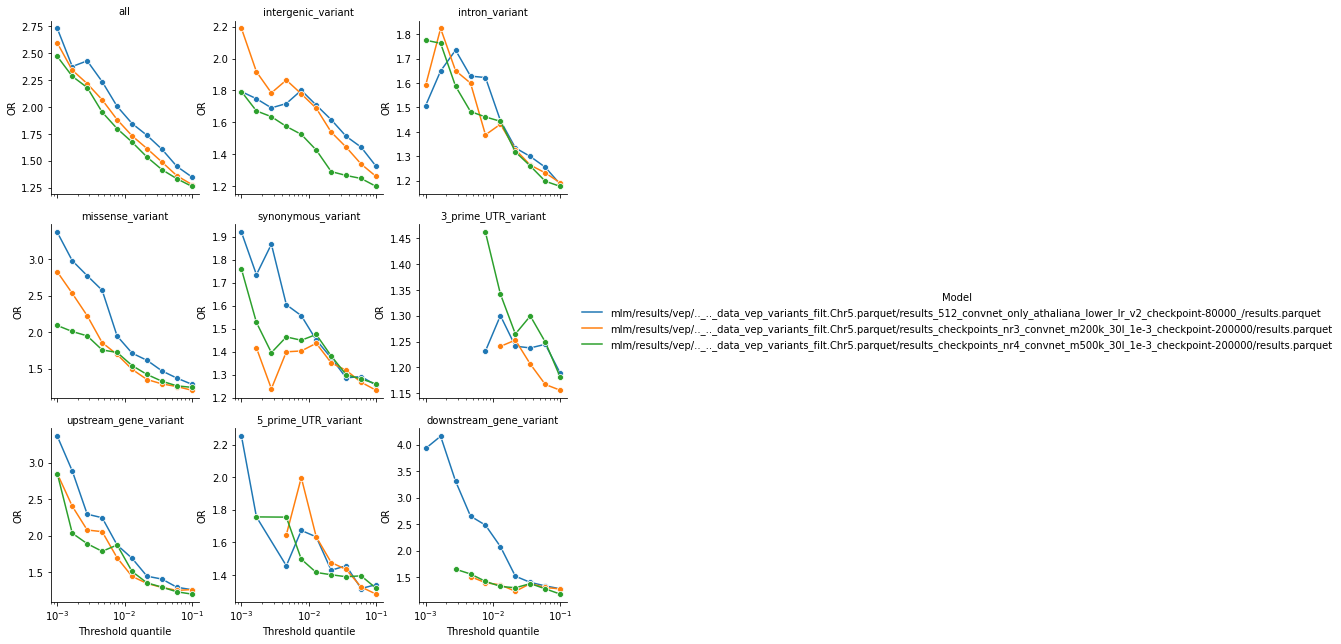

In [7]:
g = sns.relplot(
    #data=results[(results.Test=="Odds-ratio")&(results.min_count >= 5)],
    #data=results[(results.Test=="Odds-ratio-bootstrap") & (results.Significant)],
    #data=results[(results.Test=="Odds-ratio") & (results.Significant) & (results.Category.isin(categories_main))],
    data=results[(results.Test=="Odds-ratio") & (results.Significant)],
    x="Threshold quantile",
    y="OR",
    hue="Model",
    #col="category_n",
    col="Category",
    height=3,
    #aspect=.7,
    kind="line",
    marker="o",
    col_wrap=3,
    #col_wrap=2,
    facet_kws={'sharey': False, 'sharex': True},
    #err_style="bars",
    #err_style=None,
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.set(xscale='log');
#plt.savefig("odds_ratios_main.svg", bbox_inches='tight')
#plt.savefig("odds_ratios_sup.pdf", bbox_inches='tight')

In [8]:
results_mw = results[results.Test=="Mann-Whitney"]
results_mw

,Threshold quantile,OR,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
40,NaN,NaN,0.000000e+00,NaN,Mann-Whitney,NaN,NaN,NaN,all,mlm/results/vep/.._.._data_vep_variants_filt.C...,True
83,NaN,NaN,9.541860e-160,NaN,Mann-Whitney,NaN,NaN,NaN,intergenic_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,True
126,NaN,NaN,1.010560e-51,NaN,Mann-Whitney,NaN,NaN,NaN,intron_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,True
169,NaN,NaN,1.047174e-108,NaN,Mann-Whitney,NaN,NaN,NaN,missense_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,True
212,NaN,NaN,4.628768e-81,NaN,Mann-Whitney,NaN,NaN,NaN,synonymous_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,True
255,NaN,NaN,8.148883e-21,NaN,Mann-Whitney,NaN,NaN,NaN,3_prime_UTR_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,True
298,NaN,NaN,2.020444e-22,NaN,Mann-Whitney,NaN,NaN,NaN,upstream_gene_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,True
341,NaN,NaN,1.642313e-37,NaN,Mann-Whitney,NaN,NaN,NaN,5_prime_UTR_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,True
384,NaN,NaN,1.001716e-16,NaN,Mann-Whitney,NaN,NaN,NaN,downstream_gene_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,True
427,NaN,NaN,0.000000e+00,NaN,Mann-Whitney,NaN,NaN,NaN,all,mlm/results/vep/.._.._data_vep_variants_filt.C...,True


In [9]:
results_mw["-log10_pvalue"] = results_mw.p_value.apply(lambda p_value: 300 if p_value==0.0 else -np.log10(p_value))

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Text(0.5, 0, 'Mann-Whitney -log10_pvalue')

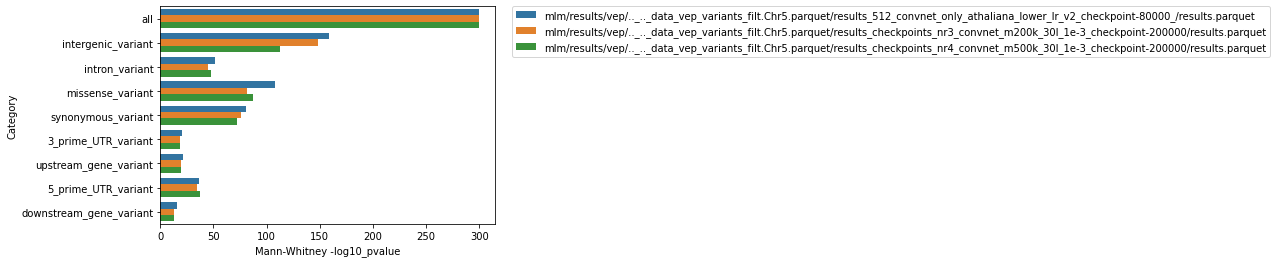

In [10]:
sns.barplot(
    y="Category",
    x="-log10_pvalue",
    hue="Model",
    data=results_mw,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel("Mann-Whitney -log10_pvalue")
#plt.savefig("mann_whitney.pdf", bbox_inches='tight')

In [11]:
results_auroc = results[results.Test=="AUROC"]
results_auroc

,Threshold quantile,OR,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
41,NaN,NaN,NaN,NaN,AUROC,NaN,0.534661,NaN,all,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
84,NaN,NaN,NaN,NaN,AUROC,NaN,0.530999,NaN,intergenic_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
127,NaN,NaN,NaN,NaN,AUROC,NaN,0.521803,NaN,intron_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
170,NaN,NaN,NaN,NaN,AUROC,NaN,0.537160,NaN,missense_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
213,NaN,NaN,NaN,NaN,AUROC,NaN,0.535408,NaN,synonymous_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
256,NaN,NaN,NaN,NaN,AUROC,NaN,0.526181,NaN,3_prime_UTR_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
299,NaN,NaN,NaN,NaN,AUROC,NaN,0.528856,NaN,upstream_gene_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
342,NaN,NaN,NaN,NaN,AUROC,NaN,0.541370,NaN,5_prime_UTR_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
385,NaN,NaN,NaN,NaN,AUROC,NaN,0.527292,NaN,downstream_gene_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
428,NaN,NaN,NaN,NaN,AUROC,NaN,0.532014,NaN,all,mlm/results/vep/.._.._data_vep_variants_filt.C...,False


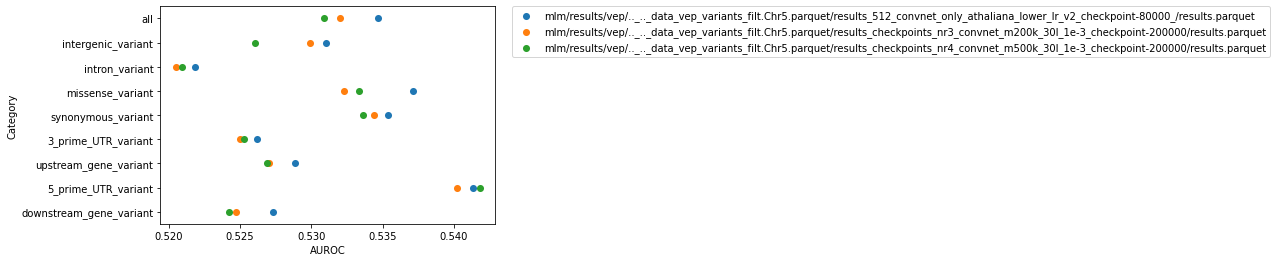

In [12]:
sns.pointplot(
    y="Category",
    x="AUROC",
    hue="Model",
    data=results_auroc,
    join=False,
    scale=0.8,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("auroc.pdf", bbox_inches='tight')

In [13]:
results_auprc = results[results.Test=="AUPRC"]
results_auprc

,Threshold quantile,OR,p_value,min_count,Test,bootstrap_seed,AUROC,AUPRC,Category,Model,Significant
42,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.597648,all,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
85,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.615731,intergenic_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
128,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.547799,intron_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
171,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.658285,missense_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
214,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.497990,synonymous_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
257,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.587234,3_prime_UTR_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
300,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.602720,upstream_gene_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
343,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.614353,5_prime_UTR_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
386,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.596519,downstream_gene_variant,mlm/results/vep/.._.._data_vep_variants_filt.C...,False
429,NaN,NaN,NaN,NaN,AUPRC,NaN,NaN,0.594034,all,mlm/results/vep/.._.._data_vep_variants_filt.C...,False


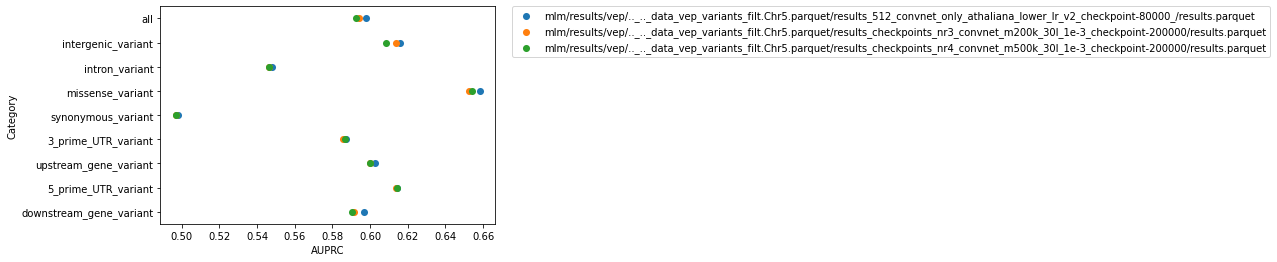

In [14]:
sns.pointplot(
    y="Category",
    x="AUPRC",
    hue="Model",
    data=results_auprc,
    join=False,
    scale=0.8,
)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#plt.savefig("auprc.pdf", bbox_inches='tight')

In [20]:
#df1 = pd.read_parquet(f"../plantbert/chromatin/vep_full_half1_DNABERT.parquet")
#df2 = pd.read_parquet(f"../plantbert/chromatin/vep_full_half2_DNABERT.parquet")
#df = pd.concat([df1, df2], ignore_index=True)
#df.to_parquet("../plantbert/chromatin/vep_full_DNABERT.parquet", index=False)

In [58]:
df = compute_vep_scores("../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet", n_bootstrap=1)[1]
#df = compute_vep_scores("mlm/results_512_convnet_checkpoint-1000000",)
#df = compute_vep_scores("PhyloP")[1]
df

../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet


,chromosome,pos,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,AF,PhastCons,PhyloP,Status,model_score
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,0.908695,0.180943,0.000041,-2.247958,Common,0.908695
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-0.672902,0.000958,0.005789,-0.031569,Rare,-0.672902
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,-0.973776,0.000941,0.004241,0.006849,Rare,-0.973776
5,Chr5,538,C,T,2,2158,AT5G01010.2,4456,intergenic_variant,1.023542,0.000927,0.001401,-1.437007,Rare,1.023542
6,Chr5,540,T,G,2,2194,AT5G01010.2,4454,intergenic_variant,-0.463521,0.000912,0.001881,0.066429,Rare,-0.463521
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319359,Chr5,26974850,C,T,2,2028,AT5G67640.1,-4209,intergenic_variant,-0.065792,0.000986,0.038742,-0.295663,Rare,-0.065792
1319360,Chr5,26974862,G,A,2,2024,AT5G67640.1,-4221,intergenic_variant,1.312950,0.000988,0.440595,0.574454,Rare,1.312950
1319364,Chr5,26974883,A,C,2,2062,AT5G67640.1,-4242,intergenic_variant,0.216148,0.000970,0.029070,0.328652,Rare,0.216148
1319366,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,0.834823,0.000976,0.000014,-1.248585,Rare,0.834823


In [59]:
consequence_scores = df.groupby("consequence").agg({"model_score": "mean", "pos": "size"}).rename(columns={"model_score": "mean_model_score", "pos": "counts"}).reset_index()
consequence_scores = consequence_scores[~consequence_scores.consequence.str.contains(',')]
consequence_scores = consequence_scores.sort_values("mean_model_score")
consequence_scores.sort_values("mean_model_score")

,consequence,mean_model_score,counts
460,splice_donor_variant,-3.192304,316
476,stop_gained,-2.855207,2337
451,non_coding_transcript_variant,-2.611817,2
456,splice_acceptor_variant,-2.523158,307
473,start_lost,-2.318925,186
408,missense_variant,-0.528974,126449
315,intergenic_variant,-0.479652,258967
139,5_prime_UTR_variant,-0.433945,32502
435,non_coding_transcript_exon_variant,-0.393452,6396
480,stop_lost,-0.341746,151


In [60]:
consequence_scores = consequence_scores[consequence_scores.counts >= 100]
consequence_scores

,consequence,mean_model_score,counts
460,splice_donor_variant,-3.192304,316
476,stop_gained,-2.855207,2337
456,splice_acceptor_variant,-2.523158,307
473,start_lost,-2.318925,186
408,missense_variant,-0.528974,126449
315,intergenic_variant,-0.479652,258967
139,5_prime_UTR_variant,-0.433945,32502
435,non_coding_transcript_exon_variant,-0.393452,6396
480,stop_lost,-0.341746,151
488,upstream_gene_variant,-0.309954,38330


In [61]:
consequence_scores["consequence"] = consequence_scores.consequence + " (n=" + consequence_scores.counts.astype(str) + ")"
consequence_scores

,consequence,mean_model_score,counts
460,splice_donor_variant (n=316),-3.192304,316
476,stop_gained (n=2337),-2.855207,2337
456,splice_acceptor_variant (n=307),-2.523158,307
473,start_lost (n=186),-2.318925,186
408,missense_variant (n=126449),-0.528974,126449
315,intergenic_variant (n=258967),-0.479652,258967
139,5_prime_UTR_variant (n=32502),-0.433945,32502
435,non_coding_transcript_exon_variant (n=6396),-0.393452,6396
480,stop_lost (n=151),-0.341746,151
488,upstream_gene_variant (n=38330),-0.309954,38330


Text(0, 0.5, '')

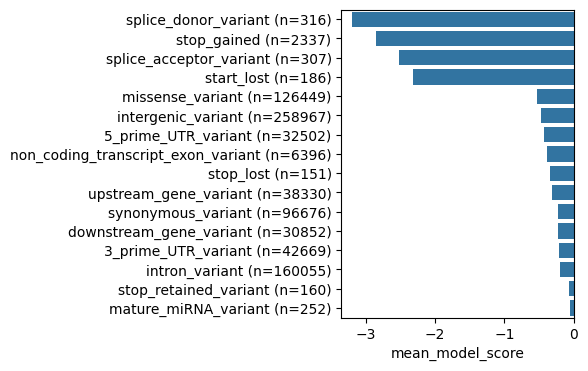

In [62]:
plt.figure(figsize=(3,4))
sns.barplot(
    data=consequence_scores,
    y="consequence", x="mean_model_score", color="C0"
);
plt.ylabel("")
#plt.savefig("model_score_by_consequence.svg", bbox_inches='tight')

In [63]:
odds_ratio, p_value, min_counts = compute_odds_ratio(df[df.consequence=="upstream_gene_variant"], 1e-3, print_table=True)
odds_ratio, p_value, min_counts

Status  ModelScoreTier
Common  High              16231
        Low                   7
Rare    High              22060
        Low                  32
dtype: int64


(3.3635021370288825, 0.0011324027518736337, 7)

In [65]:
odds_ratio, p_value, min_counts = compute_odds_ratio(df[df.consequence=="missense_variant"], 1e-3, print_table=True)
odds_ratio, p_value, min_counts

Status  ModelScoreTier
Common  High              46960
        Low                  19
Rare    High              79362
        Low                 108
dtype: int64


(3.3634551336381326, 2.8720652790674523e-08, 19)

In [67]:
odds_ratio, p_value, min_counts = compute_odds_ratio(df[df.consequence=="downstream_gene_variant"], 1e-3, print_table=True)
odds_ratio, p_value, min_counts

Status  ModelScoreTier
Common  High              13273
        Low                   5
Rare    High              17548
        Low                  26
dtype: int64


(3.9331889674036926, 0.0014327749252381421, 5)

In [71]:
compute_odds_ratio(df[df.consequence=="downstream_gene_variant"], 1e-3, print_table=True, bootstrap_seed=41)

Status  ModelScoreTier
Common  High              13227
        Low                   3
Rare    High              17594
        Low                  28
dtype: int64


(7.016710242127998, 6.267825171337211e-05, 3)

In [72]:
compute_odds_ratio(df, 1e-3, print_table=True)

Status  ModelScoreTier
Common  High              394533
        Low                  200
Rare    High              511805
        Low                  708
dtype: int64


(2.7288651341819636, 4.944033566801854e-42, 200)

In [2]:
#df = pd.read_parquet("../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_ftAth_alone_checkpoint-1000000/results.parquet")
#df = pd.read_parquet("../plantbert/mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_checkpoints_512_no_repeats_convnet_pretrained_v2_checkpoint-200000/results.parquet")
df = pd.read_parquet("mlm/results/vep/.._.._data_vep_variants_filt.Chr5.parquet/results_512_convnet_only_athaliana_lower_lr_v2_checkpoint-80000_/results.parquet")

df.rename(columns=dict(chromosome="chrom", pos="start"), inplace=True)
df["end"] = df.start + 1
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,0.908695,501
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-0.672902,505
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-0.493804,506
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,0.908161,511
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,-0.973776,513
...,...,...,...,...,...,...,...,...,...,...,...
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,0.977460,26974898
1444081,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,0.834823,26974908
1444082,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,0.286601,26974914
1444083,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,0.865547,26974919


In [3]:
#df = bf.coverage(df, repeats)
#df

In [4]:
#df = df.query('coverage == 0')
#df

In [5]:
df = df[df.AN >= 2000]
df = df[(df.AC != 0) & (df.AC != df.AN)]
df["AF"] = df.AC / df.AN
df = df[df.AC/df.AN < 0.5]
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,0.908695,501,0.180943
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-0.672902,505,0.000958
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-0.493804,506,0.001896
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,0.908161,511,0.002828
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,-0.973776,513,0.000941
...,...,...,...,...,...,...,...,...,...,...,...,...
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,0.977460,26974898,0.002893
1444081,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,0.834823,26974908,0.000976
1444082,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,0.286601,26974914,0.002938
1444083,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,0.865547,26974919,0.001957


In [6]:
df = df.sort_values("model_llr")
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF
914348,Chr5,17457725,A,C,6,2220,AT5G43440.1,-1068,"missense_variant,missense_variant",-11.925460,17457726,0.002703
584660,Chr5,10847061,T,G,2,2258,AT5G28823.1,-7235,intergenic_variant,-11.657471,10847062,0.000886
278453,Chr5,5559261,G,C,132,2230,AT5G16910.1,-2418,"splice_donor_variant,splice_donor_variant,spli...",-11.638224,5559262,0.059193
1018207,Chr5,19180560,T,G,2,2096,AT5G47230.1,621,missense_variant,-11.492754,19180561,0.000954
918081,Chr5,17519717,A,T,14,2132,AT5G43610.1,638,stop_gained,-11.477449,17519718,0.006567
...,...,...,...,...,...,...,...,...,...,...,...,...
747615,Chr5,14784707,C,A,140,2162,AT5G37320.1,6776,intergenic_variant,9.662699,14784708,0.064755
727779,Chr5,14263093,A,T,52,2192,AT5G36220.1,-7060,intergenic_variant,9.683491,14263094,0.023723
106410,Chr5,1904633,A,C,154,2096,AT5G06260.1,468,"5_prime_UTR_variant,missense_variant,missense_...",9.768132,1904634,0.073473
671755,Chr5,13349668,C,T,432,2200,AT5G35080.1,7149,intergenic_variant,10.303165,13349669,0.196364


In [7]:
df.head(10)

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF
914348,Chr5,17457725,A,C,6,2220,AT5G43440.1,-1068,"missense_variant,missense_variant",-11.925460,17457726,0.002703
584660,Chr5,10847061,T,G,2,2258,AT5G28823.1,-7235,intergenic_variant,-11.657471,10847062,0.000886
278453,Chr5,5559261,G,C,132,2230,AT5G16910.1,-2418,"splice_donor_variant,splice_donor_variant,spli...",-11.638224,5559262,0.059193
1018207,Chr5,19180560,T,G,2,2096,AT5G47230.1,621,missense_variant,-11.492754,19180561,0.000954
918081,Chr5,17519717,A,T,14,2132,AT5G43610.1,638,stop_gained,-11.477449,17519718,0.006567
516771,Chr5,9950018,T,G,6,2016,AT5G27920.1,-5240,intergenic_variant,-11.447230,9950019,0.002976
599024,Chr5,11010456,T,G,2,2046,AT5G29000.2,13819,intergenic_variant,-11.234517,11010457,0.000978
1209810,Chr5,22484780,G,C,2,2024,AT5G55507.1,932,"downstream_gene_variant,non_coding_transcript_...",-11.231179,22484781,0.000988
352083,Chr5,6973376,A,C,2,2234,AT5G20620.1,1570,"missense_variant,missense_variant",-11.203946,6973377,0.000895
271061,Chr5,5426200,C,A,2,2240,AT5G16580.1,1272,stop_gained,-11.187574,5426201,0.000893


In [8]:
df.tail(10)

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF
615183,Chr5,11420382,G,A,6,2138,AT5G30495.1,40255,intergenic_variant,9.210835,11420383,0.002806
616318,Chr5,11441592,G,T,792,2066,AT5G30495.1,61465,intergenic_variant,9.411280,11441593,0.383349
750472,Chr5,14824800,T,G,968,2060,AT5G37380.4,-5504,intergenic_variant,9.420025,14824801,0.469903
655640,Chr5,13069311,G,T,6,2142,AT5G34869.1,8276,intergenic_variant,9.507157,13069312,0.002801
509816,Chr5,9838960,C,A,18,2086,AT5G27780.1,353,missense_variant,9.535076,9838961,0.008629
747615,Chr5,14784707,C,A,140,2162,AT5G37320.1,6776,intergenic_variant,9.662699,14784708,0.064755
727779,Chr5,14263093,A,T,52,2192,AT5G36220.1,-7060,intergenic_variant,9.683491,14263094,0.023723
106410,Chr5,1904633,A,C,154,2096,AT5G06260.1,468,"5_prime_UTR_variant,missense_variant,missense_...",9.768132,1904634,0.073473
671755,Chr5,13349668,C,T,432,2200,AT5G35080.1,7149,intergenic_variant,10.303165,13349669,0.196364
41306,Chr5,707347,G,T,478,2054,AT5G03020.1,90,"downstream_gene_variant,missense_variant",11.116516,707348,0.232717


In [9]:
df["model_llr_percentile_bin"] = pd.qcut(df.model_llr, 100, labels=False)
df.model_llr_percentile_bin.value_counts()

95    14061
0     14060
61    14060
72    14060
71    14060
      ...  
27    14060
99    14060
33    14059
66    14059
96    14059
Name: model_llr_percentile_bin, Length: 100, dtype: int64

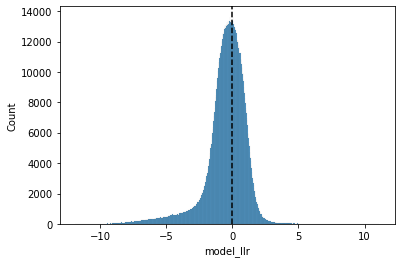

In [10]:
sns.histplot(
    data=df,
    x="model_llr"
)
plt.axvline(0, linestyle="--", color="black")

In [11]:
mean_AF = df.AF.mean()
mean_AF

0.02619508254559359

Text(0.5, 0, 'GPN score percentile bin')

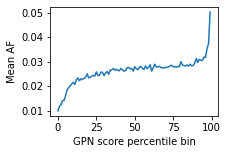

In [12]:
plt.figure(figsize=(3,2))
#g = sns.pointplot(
g = sns.lineplot(
    data=df,
    x="model_llr_percentile_bin",
    y="AF",
    color="C0",
    #join=False,
    ci=None,
    #s=2,
    markers=True,
)
#plt.axhline(mean_AF, linestyle="--", color="grey")
plt.ylabel("Mean AF")
plt.xlabel("GPN score percentile bin")
#plt.savefig("model_score_vs_AF.svg", bbox_inches='tight')

In [13]:
df.model_llr_percentile_bin.describe()

count    1.405998e+06
mean     4.950000e+01
std      2.886609e+01
min      0.000000e+00
25%      2.425000e+01
50%      4.950000e+01
75%      7.475000e+01
max      9.900000e+01
Name: model_llr_percentile_bin, dtype: float64

Text(0.5, 1.0, 'Top 1% GPN scores')

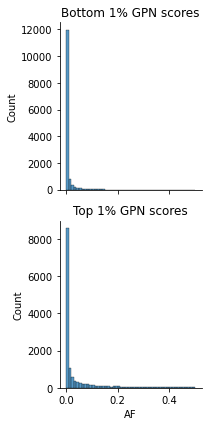

In [14]:
g = sns.displot(
    data=df[df.model_llr_percentile_bin.isin([0, 99])],
    x="AF",
    row="model_llr_percentile_bin",
    row_order=[0,99],
    kind="hist",
    #stat="density",
    facet_kws=dict(sharey=False),
    height=3.0,
    aspect=1.0,
    bins=50,
)
#g.set_titles(row_template="{row_name}")
g.axes[0][0].set_title("Bottom 1% GPN scores")
g.axes[1][0].set_title("Top 1% GPN scores")
#plt.xlabel("GPN score")
#plt.savefig("model_score_and_AF_hist.pdf", bbox_inches="tight")

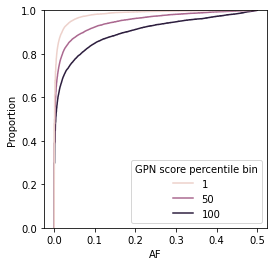

In [24]:
df["GPN score percentile bin"] = df.model_llr_percentile_bin + 1
plt.figure(figsize=(4,4))
g = sns.ecdfplot(
    data=df[df["GPN score percentile bin"].isin([1, 50, 100])],
    hue="GPN score percentile bin",
    x="AF",
    #stat="probability",
    #bins=10,
    #multiple="dodge",
)
plt.savefig("mlm/results/plots/model_score_and_AF_cdf.pdf", bbox_inches="tight")

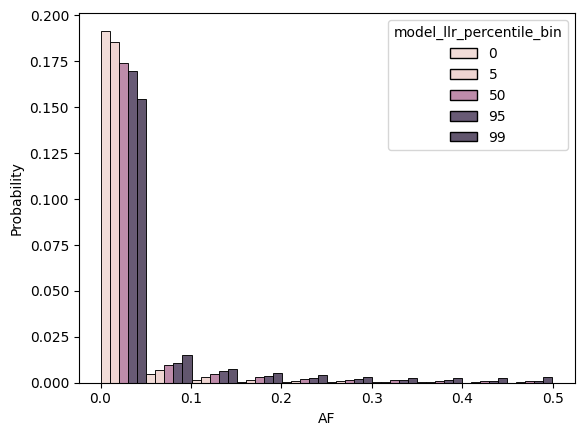

In [54]:
g = sns.histplot(
    data=df[df.model_llr_percentile_bin.isin([0, 5, 50, 95, 99])],
    hue="model_llr_percentile_bin",
    x="AF",
    stat="probability",
    bins=10,
    multiple="dodge",
)

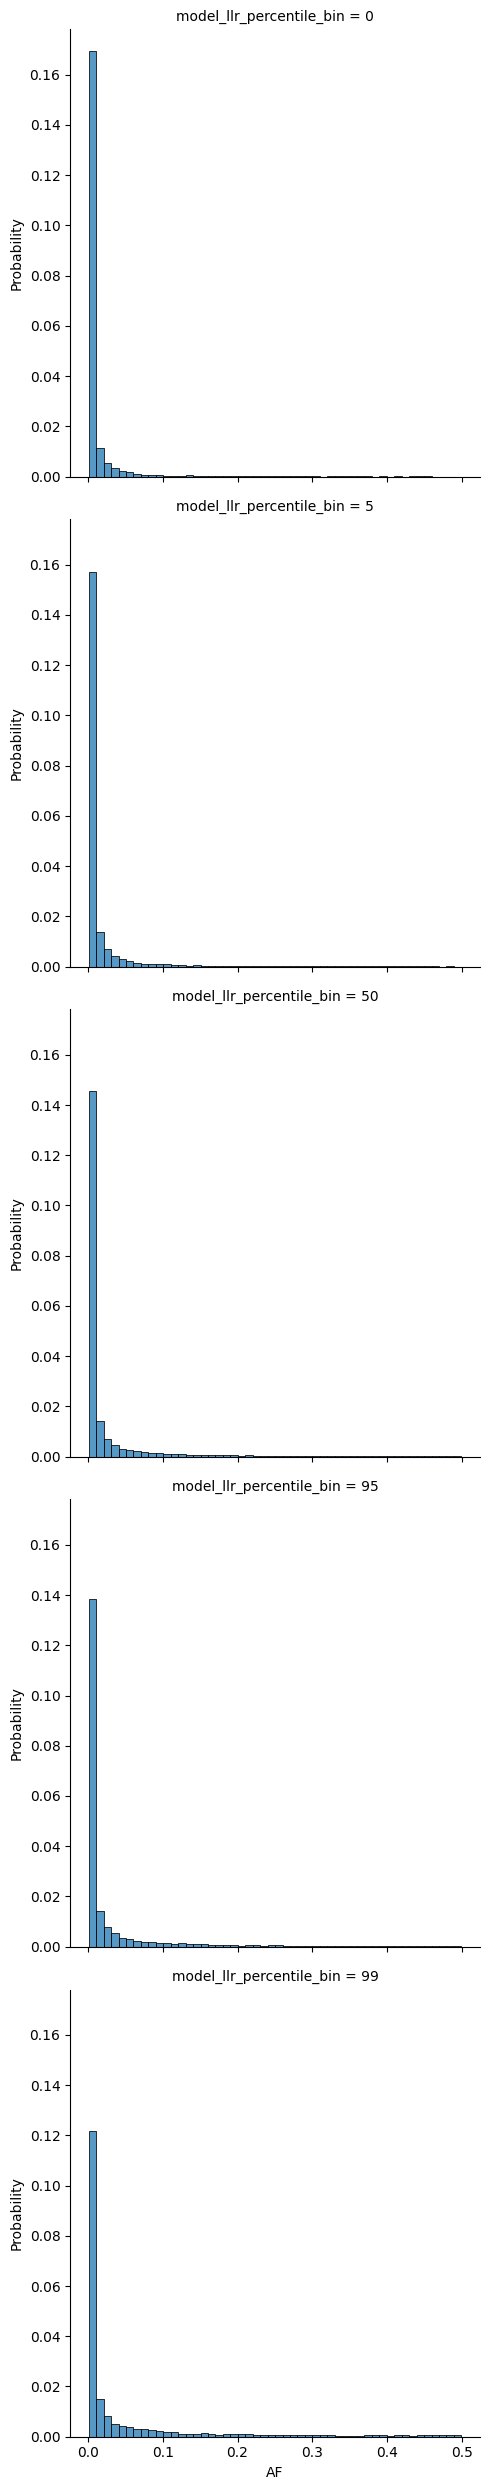

In [55]:
g = sns.displot(
    data=df[df.model_llr_percentile_bin.isin([0, 5, 50, 95, 99])],
    row="model_llr_percentile_bin",
    x="AF",
    stat="probability",
    bins=50,
)

In [7]:
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.679222,501,0.180943
1,Chr5,504,T,C,2,2088,AT5G01010.2,4490,intergenic_variant,-1.429612,505,0.000958
2,Chr5,505,A,G,4,2110,AT5G01010.2,4489,intergenic_variant,-0.920169,506,0.001896
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.463465,511,0.002828
4,Chr5,512,A,G,2,2126,AT5G01010.2,4482,intergenic_variant,0.410461,513,0.000941
...,...,...,...,...,...,...,...,...,...,...,...,...
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-0.909240,26974898,0.002893
1444081,Chr5,26974907,G,A,2,2050,AT5G67640.1,-4266,intergenic_variant,-0.045258,26974908,0.000976
1444082,Chr5,26974913,C,T,6,2042,AT5G67640.1,-4272,intergenic_variant,0.925370,26974914,0.002938
1444083,Chr5,26974918,C,T,4,2044,AT5G67640.1,-4277,intergenic_variant,-0.580203,26974919,0.001957


In [8]:
# https://aragwas.1001genomes.org/api/associations/download/?&chr=5&annotation=ns&annotation=s&annotation=in&annotation=i&maf=1&maf=1-5&maf=5-10&maf=10&mac=5&type=genic&type=non-genic&significant=p

In [65]:
aragwas = pd.read_csv("aragwas_associations_chr_5_significant_permutation.csv")
aragwas["snp.position"] -= 1
aragwas.drop_duplicates("score", keep=False, inplace=True)
aragwas

/global/software/sl-7.x86_64/modules/langs/python/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (94,98,99,102,106,107,108,109,110,111,113,114,115,116) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,snp.chr,snp.position,score,maf,mac,study.name,study.id,study.phenotype.name,study.genotype.name,study.thresholds,...,snp.annotations.10.gene_name,snp.annotations.10.transcript_id,snp.annotations.10.effect,snp.annotations.10.impact,snp.annotations.10.rank,snp.annotations.11.gene_name,snp.annotations.11.transcript_id,snp.annotations.11.effect,snp.annotations.11.impact,snp.annotations.11.rank
4,chr5,2758120,29.582640,0.055888,28,"('clim-gs10_raw_Full imputed genotype_amm',)",577,clim-gs10,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,chr5,4640223,29.087025,0.073684,7,"('YEL__raw_Full imputed genotype_amm',)",28,YEL,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,chr5,26788831,27.159486,0.049900,25,"('clim-bio4_raw_Full imputed genotype_amm',)",567,clim-bio4,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,chr5,5513288,26.747298,0.013972,7,"('clim-gs5_raw_Full imputed genotype_amm',)",583,clim-gs5,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,chr5,26872609,24.366746,0.043912,22,"('clim-bio4_raw_Full imputed genotype_amm',)",567,clim-bio4,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21475,chr5,13741411,6.830658,0.107527,10,"('Li7_raw_Full imputed genotype_amm',)",101,Li7,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21476,chr5,18503193,6.806693,0.198864,35,"('Anthocyanin_16_raw_Full imputed genotype_amm',)",61,Anthocyanin 16,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21477,chr5,26227768,6.720372,0.236559,22,"('B11_raw_Full imputed genotype_amm',)",54,B11,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
21489,chr5,13102074,6.438809,0.015968,8,"('clim-pet3_raw_Full imputed genotype_amm',)",597,clim-pet3,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
list(aragwas.columns)

['snp.chr',
 'snp.position',
 'score',
 'maf',
 'mac',
 'study.name',
 'study.id',
 'study.phenotype.name',
 'study.genotype.name',
 'study.thresholds',
 'overFDR',
 'overBonferroni',
 'overPermutation',
 'snp.ref',
 'snp.alt',
 'snp.coding',
 'snp.gene_name',
 'snp.annotations',
 'study.thresholds.0.name',
 'study.thresholds.0.value',
 'study.thresholds.1.name',
 'study.thresholds.1.value',
 'study.thresholds.2.name',
 'study.thresholds.2.value',
 'study.thresholds.3.name',
 'study.thresholds.3.value',
 'study.thresholds.4.name',
 'study.thresholds.4.value',
 'snp.annotations.0.gene_name',
 'snp.annotations.0.transcript_id',
 'snp.annotations.0.effect',
 'snp.annotations.0.impact',
 'snp.annotations.0.rank',
 'snp.annotations.1.gene_name',
 'snp.annotations.1.transcript_id',
 'snp.annotations.1.effect',
 'snp.annotations.1.impact',
 'snp.annotations.1.rank',
 'snp.annotations.2.gene_name',
 'snp.annotations.2.transcript_id',
 'snp.annotations.2.function',
 'snp.annotations.2.impact',


In [38]:
aragwas[["mac", "maf"]].describe()

,mac,maf
count,21502.000000,21502.000000
mean,9.043531,0.018309
std,10.769814,0.019067
min,6.000000,0.005671
25%,6.000000,0.012000
50%,7.000000,0.013972
75%,8.000000,0.016000
max,520.000000,0.491493


In [66]:
aragwas["snp.position"].unique().shape

(1131,)

In [67]:
# checked the first one 14024713 and it was filtered out because AN less than 2000
list(set(aragwas["snp.position"]).difference(df.start.values))[:10]

[14012422,
 12197919,
 11345951,
 9048099,
 12668964,
 16158769,
 17608768,
 12615745,
 1343559,
 10137671]

In [68]:
len(set(df.start.values).intersection(aragwas["snp.position"].values))

619

In [63]:
aragwas.drop_duplicates()

,snp.chr,snp.position,score,maf,mac,study.name,study.id,study.phenotype.name,study.genotype.name,study.thresholds,...,snp.annotations.10.transcript_id,snp.annotations.10.effect,snp.annotations.10.impact,snp.annotations.10.rank,snp.annotations.11.gene_name,snp.annotations.11.transcript_id,snp.annotations.11.effect,snp.annotations.11.impact,snp.annotations.11.rank,AN
0,chr5,902185,29.967642,0.037681,13,"('Co59_raw_Full imputed genotype_amm',)",279,Co59,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,345.0
1,chr5,902307,29.967642,0.037681,13,"('Co59_raw_Full imputed genotype_amm',)",279,Co59,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,345.0
2,chr5,26807057,29.632889,0.047904,24,"('clim-bio4_raw_Full imputed genotype_amm',)",567,clim-bio4,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.0
3,chr5,26807056,29.632889,0.047904,24,"('clim-bio4_raw_Full imputed genotype_amm',)",567,clim-bio4,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.0
4,chr5,2758120,29.582640,0.055888,28,"('clim-gs10_raw_Full imputed genotype_amm',)",577,clim-gs10,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,501.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21497,chr5,26813487,6.394157,0.129032,12,"('B11_raw_Full imputed genotype_amm',)",54,B11,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,93.0
21498,chr5,18571032,6.322100,0.409938,66,"('GR21_raw_Full imputed genotype_amm',)",294,GR21,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.0
21499,chr5,18571737,6.322100,0.409938,66,"('GR21_raw_Full imputed genotype_amm',)",294,GR21,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.0
21500,chr5,18571688,6.322100,0.409938,66,"('GR21_raw_Full imputed genotype_amm',)",294,GR21,Full imputed genotype,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,161.0


In [69]:
df = df[df.AC >= 6]
df

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF,GWAS_hit
0,Chr5,500,C,T,376,2078,AT5G01010.2,4494,downstream_gene_variant,1.679222,501,0.180943,False
3,Chr5,510,G,A,6,2122,AT5G01010.2,4484,intergenic_variant,1.463465,511,0.002828,False
9,Chr5,548,C,T,20,2182,AT5G01010.2,4446,intergenic_variant,0.359509,549,0.009166,False
11,Chr5,558,G,A,12,2176,AT5G01010.2,4436,intergenic_variant,-0.758004,559,0.005515,False
12,Chr5,559,A,C,10,2036,AT5G01010.2,4435,intergenic_variant,2.038264,560,0.004912,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1444072,Chr5,26974818,G,A,10,2014,AT5G67640.1,-4177,intergenic_variant,1.712686,26974819,0.004965,False
1444076,Chr5,26974865,G,A,6,2046,AT5G67640.1,-4224,intergenic_variant,1.352494,26974866,0.002933,False
1444077,Chr5,26974868,C,T,6,2042,AT5G67640.1,-4227,intergenic_variant,0.641163,26974869,0.002938,False
1444080,Chr5,26974897,C,T,6,2074,AT5G67640.1,-4256,intergenic_variant,-0.909240,26974898,0.002893,False


In [70]:
df["GWAS_hit"] = df.start.isin(aragwas["snp.position"].unique())
df.GWAS_hit.value_counts()

False    699322
True        619
Name: GWAS_hit, dtype: int64

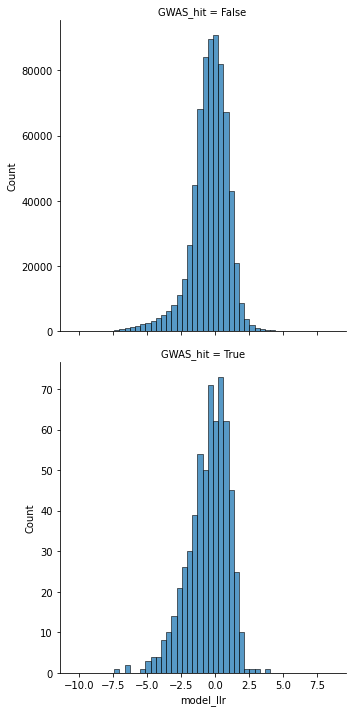

In [71]:
sns.displot(
    data=df,
    row="GWAS_hit",
    x="model_llr",
    stat="count",
    kind="hist",
    facet_kws=dict(sharey=False),
    bins=50,
)

In [57]:
aragwas_groupby = aragwas.groupby("snp.position").score.max().to_frame()
aragwas_groupby

,score
snp.position,
569,12.467616
20084,10.293022
89437,10.708900
150572,10.347442
442999,13.965251
...,...
26970982,14.217024
26972146,14.217024
26974038,14.217024


In [58]:
df5 = df.merge(aragwas_groupby, how="inner", left_on="start", right_index=True)
df5

,chrom,start,ref,alt,AC,AN,closest_TSS,dist_to_TSS,consequence,model_llr,end,AF,GWAS_hit,score
17,Chr5,569,G,A,24,2142,AT5G01010.2,4425,intergenic_variant,0.674958,570,0.011204,True,12.467616
1367,Chr5,20084,C,T,26,2188,AT5G01050.1,728,stop_gained,-4.307332,20085,0.011883,True,10.293022
5019,Chr5,89437,A,G,30,2188,AT5G01220.1,549,"intron_variant,intron_variant",-0.694389,89438,0.013711,True,10.708900
26220,Chr5,443085,G,A,46,2070,AT5G02220.1,-939,intergenic_variant,0.003092,443086,0.022222,True,13.965251
27195,Chr5,460761,C,T,52,2092,AT5G02260.1,-2397,intergenic_variant,1.123757,460762,0.024857,True,13.965251
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1443700,Chr5,26970915,A,G,82,2168,AT5G67640.1,-274,intergenic_variant,-1.035935,26970916,0.037823,True,14.217024
1443716,Chr5,26970982,A,G,98,2140,AT5G67640.1,-341,intergenic_variant,-2.183914,26970983,0.045794,True,14.217024
1443836,Chr5,26972146,T,A,94,2126,AT5G67640.1,-1505,downstream_gene_variant,-0.252052,26972147,0.044214,True,14.217024
1443986,Chr5,26974038,G,C,98,2086,AT5G67640.1,-3397,intergenic_variant,0.740364,26974039,0.046980,True,14.217024


<AxesSubplot:xlabel='score', ylabel='model_llr'>

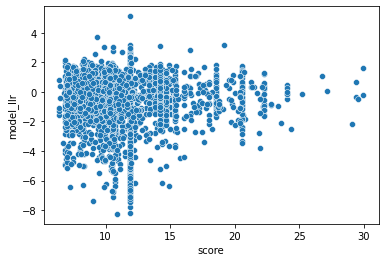

In [59]:
sns.scatterplot(
    data=df5,
    x="score",
    y="model_llr"
)